In [1]:
### Imports

import matplotlib.pyplot as plt
plt.rc('font',family='AppleGothic')
import numpy as np
import pandas as pd

In [2]:
# Load_data

data_raw = pd.read_csv('../used/data/raw_data/train.csv')
sample_submission_raw = pd.read_csv('../used/data/raw_data/sample_submission.csv')

data=data_raw.copy()
sample_submission=sample_submission_raw.copy()

In [3]:
# Data_index to timeseries

data.set_index('일시',inplace=True)
data.index=pd.to_datetime(data.index,format='%Y%m%d')
data['week']=data.index.isocalendar().week
data['day_name']=data.index.weekday
data['weekend']=data['day_name'].apply(lambda x: 0 if x<5 else 1)
data['year']=data.index.year

## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## 

sample_submission.set_index('일시',inplace=True)
sample_submission.index=pd.to_datetime(sample_submission.index,format='%Y%m%d')
sample_submission['week']=sample_submission.index.isocalendar().week
sample_submission['day_name']=sample_submission.index.weekday
sample_submission['weekend']=sample_submission['day_name'].apply(lambda x: 0 if x<5 else 1)
sample_submission['year']=sample_submission.index.year

<AxesSubplot: title={'center': '2021'}, xlabel='일시'>

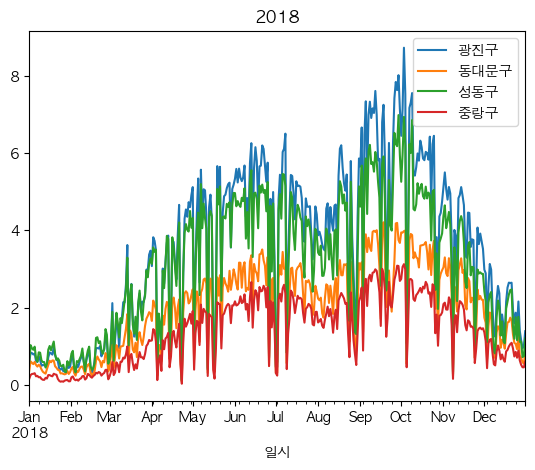

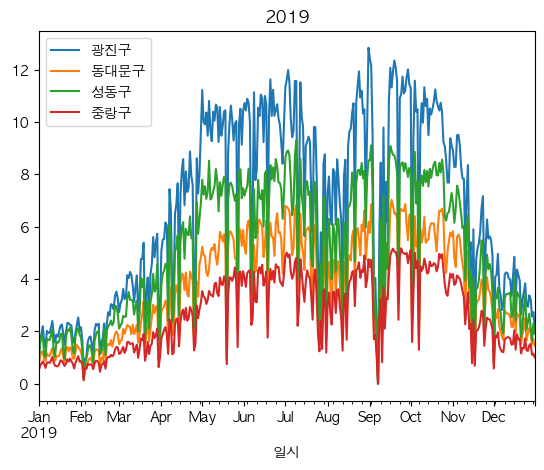

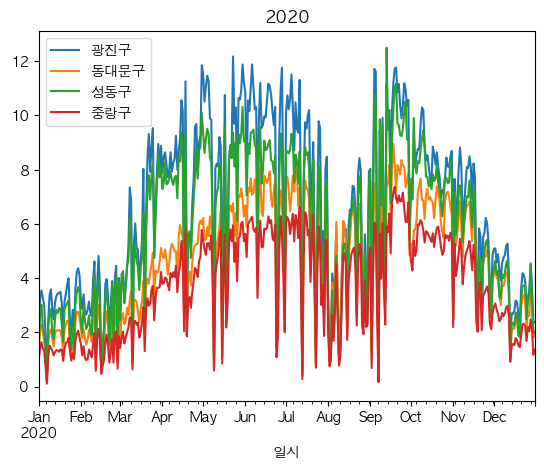

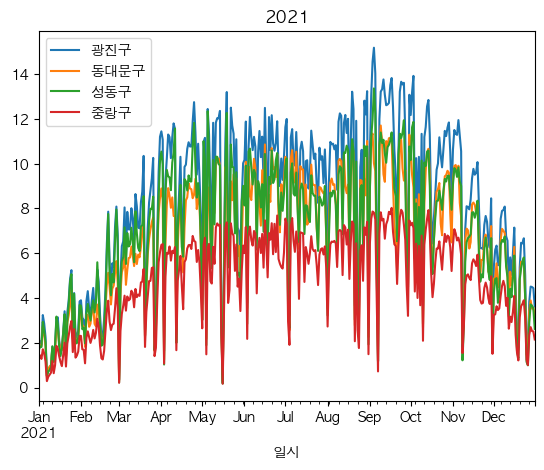

In [4]:
# raw_data yearly plot
data[data.index.year == 2018].iloc[:,:4].plot(title='2018')
data[data.index.year == 2019].iloc[:,:4].plot(title='2019')
data[data.index.year == 2020].iloc[:,:4].plot(title='2020')
data[data.index.year == 2021].iloc[:,:4].plot(title='2021')

<AxesSubplot: title={'center': '2021'}, xlabel='일시'>

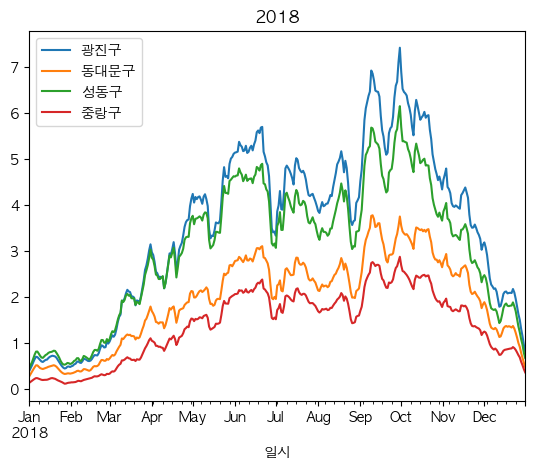

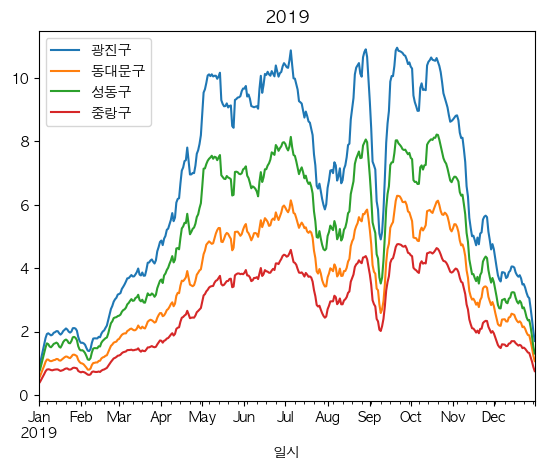

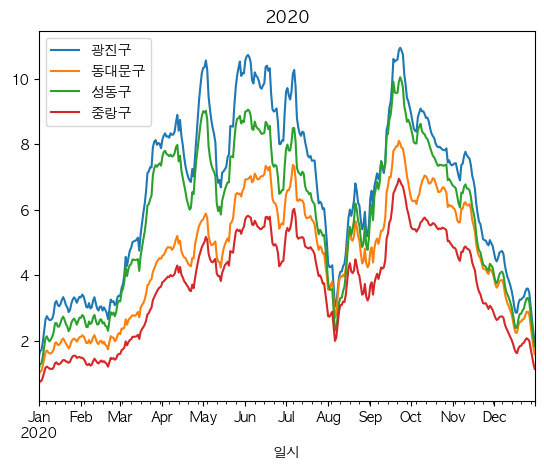

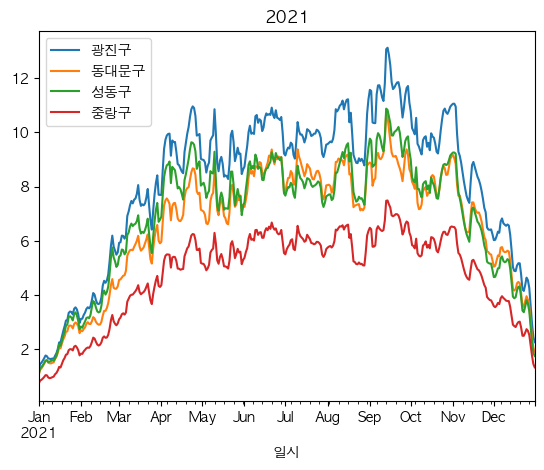

In [5]:
# smoothed_data yearly plot
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

temp_2018=data[data.index.year == 2018].iloc[:,:4]
for col in temp_2018:
    temp_2018[col] = smooth(temp_2018[col],10)
temp_2018.plot(title='2018')
temp_2019=data[data.index.year == 2019].iloc[:,:4]
for col in temp_2019:
    temp_2019[col] = smooth(temp_2019[col],10)
temp_2019.plot(title='2019')
temp_2020=data[data.index.year == 2020].iloc[:,:4]
for col in temp_2020:
    temp_2020[col] = smooth(temp_2020[col],10)
temp_2020.plot(title='2020')
temp_2021=data[data.index.year == 2021].iloc[:,:4]
for col in temp_2021:
    temp_2021[col] = smooth(temp_2021[col],10)
temp_2021.plot(title='2021')

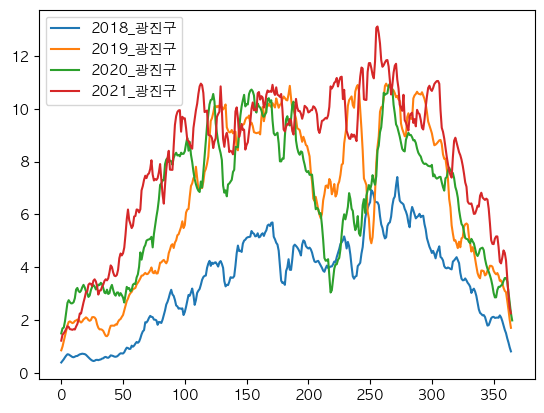

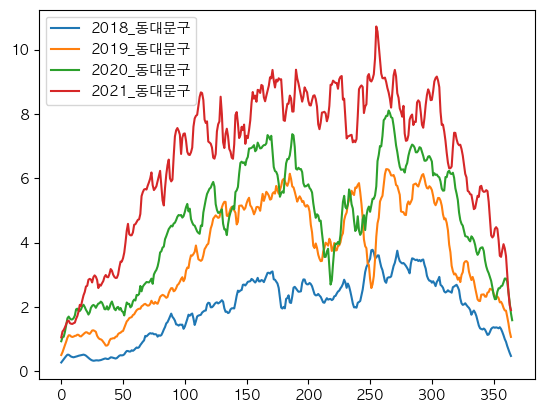

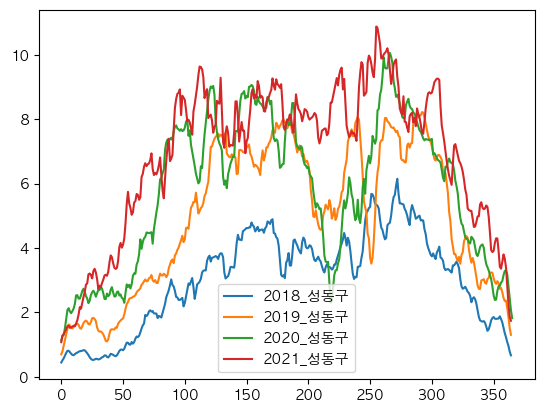

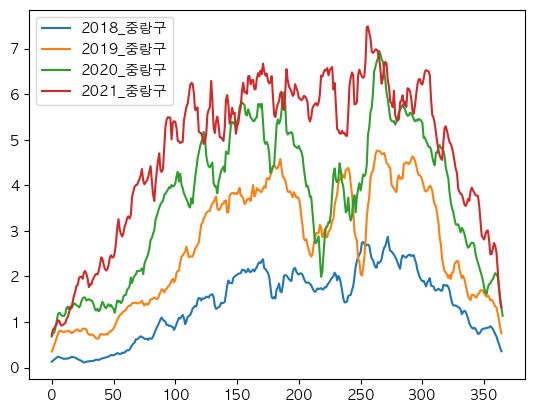

In [6]:
for i in range(4):
    temp_2018.reset_index(drop=True).iloc[:,i].plot(label=f'2018_{temp_2018.columns[i]}')
    temp_2019.reset_index(drop=True).iloc[:,i].plot(label=f'2019_{temp_2019.columns[i]}')
    temp_2020.reset_index(drop=True).iloc[:,i].plot(label=f'2020_{temp_2020.columns[i]}')
    temp_2021.reset_index(drop=True).iloc[:,i].plot(label=f'2021_{temp_2021.columns[i]}')
    plt.legend()
    plt.show()

In [7]:
# 년도별 공휴일 체크하기위한 library => 평일인 공휴일도 주말로 설정.

from pytimekr import pytimekr
def get_holiday(_year):
    holidays=[]
    for holiday in pytimekr.holidays(year=_year):
        if pytimekr.red_days(holiday) != None:
            ans = [i.strftime("%Y-%m-%d") for i in pytimekr.red_days(holiday)]
            holidays.extend(ans)
        else:
            ans=holiday.strftime("%Y-%m-%d")
            holidays.append(ans)
    return list(set(holidays))

data.loc[get_holiday(2018),'weekend'] = 1
data.loc[get_holiday(2019),'weekend'] = 1
data.loc[get_holiday(2020),'weekend'] = 1
data.loc[get_holiday(2021),'weekend'] = 1
sample_submission.loc[sorted(get_holiday(2022))[:-1],'주말평일'] ='주말'

In [8]:
# 년도별 주별 (평일,주말) 별 평균값 구하기
data_week_groupby=data.groupby(['year','week','weekend']).mean().reset_index()

In [9]:
# 년도별 주별 (평일,주말) 별 평균값 구하기
df_2018=data_week_groupby[data_week_groupby['year']==2018].iloc[:,[1,2,3,4,5,6]]
df_2019=data_week_groupby[data_week_groupby['year']==2019].iloc[:,[1,2,3,4,5,6]]
df_2020=data_week_groupby[data_week_groupby['year']==2020].iloc[:,[1,2,3,4,5,6]]
df_2021=data_week_groupby[data_week_groupby['year']==2021].iloc[:,[1,2,3,4,5,6]]

In [10]:
# 주말평일의 갭이 너무 불연속 적이라 smoothing 진행

year_df_list=[df_2018,df_2019,df_2020,df_2021]
for df in year_df_list:
    for col in df.iloc[:,2:].columns:
        df[col] = smooth(df[col],7)

In [11]:
# 각 연도별 minmaxscaling 진행
## => 모든 연도별 주간 평균을 값을 baseline으로 2022년을 예측하기 위해
from sklearn.preprocessing import MinMaxScaler
mms_2018 = MinMaxScaler()
mms_2019 = MinMaxScaler()
mms_2020 = MinMaxScaler()
mms_2021 = MinMaxScaler()

In [12]:
# 각 연도별 minmaxscaling 진행
year_df_list=[df_2018,df_2019,df_2020,df_2021]
scaler_list=[mms_2018,mms_2019,mms_2020,mms_2021]
for df,mms in zip(year_df_list,scaler_list):
    df.iloc[:,2:] = mms.fit_transform(df.iloc[:,2:])

In [13]:
# 연도별 대여량을 스케일링 한후 주별,(평일,주말별) 대여량 평균구하기
week_mean=pd.concat(year_df_list).groupby(['week','weekend']).mean().reset_index()

<AxesSubplot: >

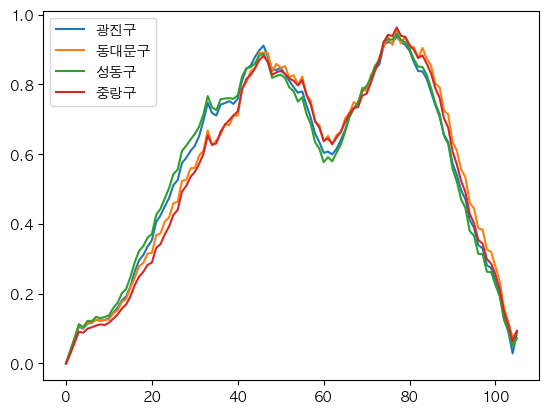

In [14]:

week_mean.iloc[:,2:].plot()

In [15]:
# 이제 minmaxscaling된 자료를 바탕으로 
# 각 년도에 맞게 inverse_transform 진행 => 2018년도 스케일의 (주간평균), 2019년도 스케일의 (주간평균),2020년도 스케일의 (주간평균),2021년도 스케일의 (주간평균)
df_2018_weekmean=pd.DataFrame(mms_2018.inverse_transform(week_mean.iloc[:,2:]),columns=week_mean.iloc[:,2:].columns)
df_2018_weekmean['week'] = week_mean['week']
df_2018_weekmean['weekend'] = week_mean['weekend']
df_2019_weekmean=pd.DataFrame(mms_2019.inverse_transform(week_mean.iloc[:,2:]),columns=week_mean.iloc[:,2:].columns)
df_2019_weekmean['week'] = week_mean['week']
df_2019_weekmean['weekend'] = week_mean['weekend']
df_2020_weekmean=pd.DataFrame(mms_2020.inverse_transform(week_mean.iloc[:,2:]),columns=week_mean.iloc[:,2:].columns)
df_2020_weekmean['week'] = week_mean['week']
df_2020_weekmean['weekend'] = week_mean['weekend']
df_2021_weekmean=pd.DataFrame(mms_2021.inverse_transform(week_mean.iloc[:,2:]),columns=week_mean.iloc[:,2:].columns)
df_2021_weekmean['week'] = week_mean['week']
df_2021_weekmean['weekend'] = week_mean['weekend']

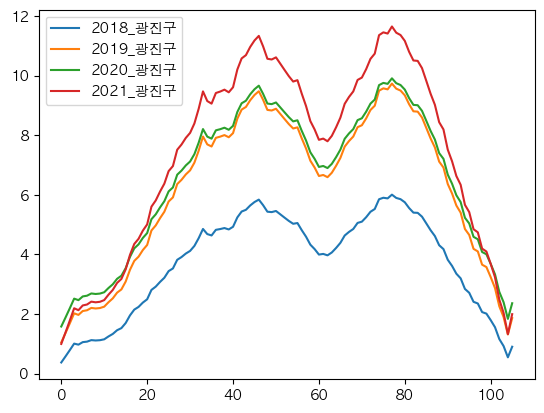

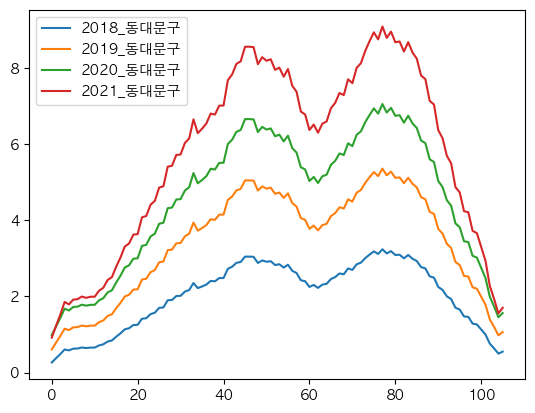

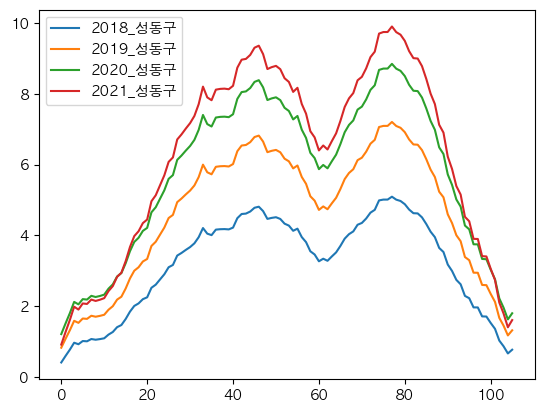

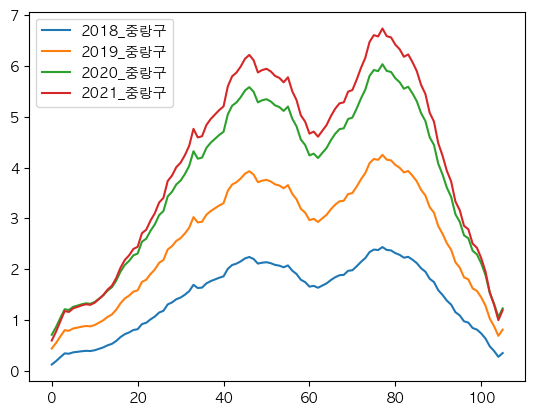

In [16]:
for i in range(4):
    df_2018_weekmean.iloc[:,i].plot(label=f'2018_{df_2018_weekmean.columns[i]}')
    df_2019_weekmean.iloc[:,i].plot(label=f'2019_{df_2019_weekmean.columns[i]}')
    df_2020_weekmean.iloc[:,i].plot(label=f'2020_{df_2020_weekmean.columns[i]}')
    df_2021_weekmean.iloc[:,i].plot(label=f'2021_{df_2021_weekmean.columns[i]}')
    plt.legend()
    plt.show()

In [17]:
df_2022_weekmean=df_2021_weekmean.copy()

In [18]:
# 각 location별 2022값 년도별 diff 차이를 활용하여, 계산
df_2022_weekmean.iloc[:,0]=df_2021_weekmean.iloc[:,0]+pd.concat([df_2018_weekmean.iloc[:,0],df_2019_weekmean.iloc[:,0],df_2020_weekmean.iloc[:,0],df_2021_weekmean.iloc[:,0]],axis=1).diff(axis=1).mean(axis=1)*3
df_2022_weekmean.iloc[:,1]=df_2021_weekmean.iloc[:,1]+pd.concat([df_2018_weekmean.iloc[:,1],df_2019_weekmean.iloc[:,1],df_2020_weekmean.iloc[:,1],df_2021_weekmean.iloc[:,1]],axis=1).diff(axis=1).mean(axis=1)*3
df_2022_weekmean.iloc[:,2]=df_2021_weekmean.iloc[:,2]+pd.concat([df_2018_weekmean.iloc[:,2],df_2019_weekmean.iloc[:,2],df_2020_weekmean.iloc[:,2],df_2021_weekmean.iloc[:,2]],axis=1).diff(axis=1).mean(axis=1)*3
df_2022_weekmean.iloc[:,3]=df_2021_weekmean.iloc[:,3]+pd.concat([df_2018_weekmean.iloc[:,3],df_2019_weekmean.iloc[:,3],df_2020_weekmean.iloc[:,3],df_2021_weekmean.iloc[:,3]],axis=1).diff(axis=1).mean(axis=1)*3

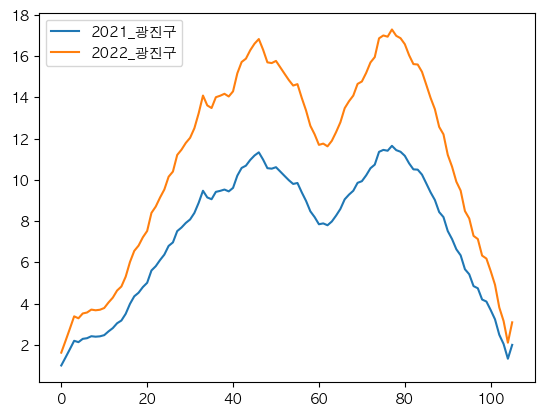

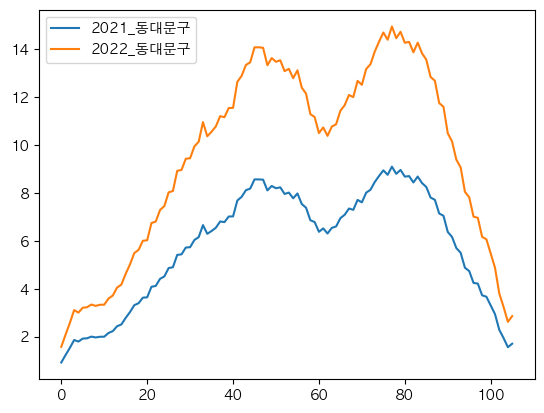

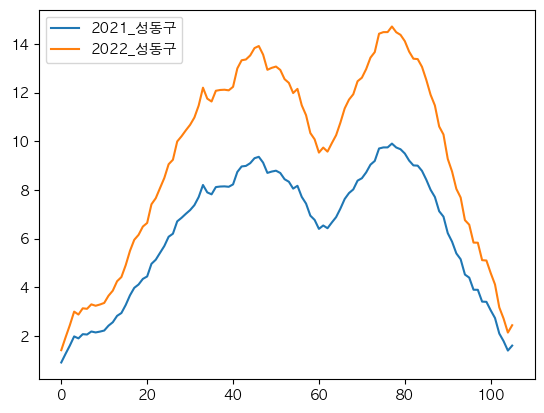

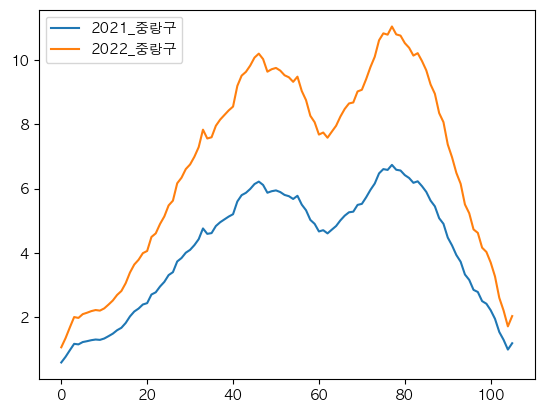

In [19]:
for i in range(4):
    df_2021_weekmean.iloc[:,i].plot(label=f'2021_{df_2021_weekmean.columns[i]}')
    df_2022_weekmean.iloc[:,i].plot(label=f'2022_{df_2022_weekmean.columns[i]}')
    plt.legend()
    plt.show()

In [20]:
# submit
sample_submission['week']=sample_submission['week'].apply(lambda x: 1 if x == 52 else x )
ans=sample_submission.merge(df_2022_weekmean,on=['week','weekend']).iloc[:,-4:]
sample_submission_raw.iloc[:,1:] = ans.values
sample_submission_raw.to_csv('final_ans.csv',index=False)